## Импорт пакетов

In [570]:
# Data Manipulation Packages
import numpy as np
import pandas as pd
import scipy.stats as sts

# Data Visualisation Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and Math Packages
import scipy.stats as sts

# Models
from sklearn.metrics import r2_score
import sktime as skt
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.table import SimpleTable

import pyreadstat
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

## 1. Взять языка: найти ряд

Данные были получены с сайта kaggle.com, полная ссылка на данные:
https://www.kaggle.com/census/retail-and-retailers-sales-time-series-collection

Ряды представляют месячные продажи определенных товаров ритейлерами в США

Мы выбрал два ряда, хотя они и не могут выступать предикторами друг друга
На самом деле в датасете было больше рядов, но мы решили взять только два

In [322]:
# Импортируем ряды
df1 = pd.read_csv("/Users/alexeysek/Desktop/HW2_Metrics/Data/MRTSSM44X72USS.csv")
df2 = pd.read_csv("/Users/alexeysek/Desktop/HW2_Metrics/Data/MRTSSM44611USN.csv")

In [323]:
# Сделаем даты месячнымииндексами
df1['date'] = df1['date'].str.slice(start=0,stop=7)
df1.index = pd.PeriodIndex(pd.to_datetime(df1['date'],format='%Y-%m'), freq="M")

df2['date'] = df2['date'].str.slice(start=0,stop=7)
df2.index = pd.PeriodIndex(pd.to_datetime(df2['date'],format='%Y-%m'), freq="M")

In [324]:
# Очистим ряды от ненужых столбцов
df1 = df1.drop(["realtime_start","realtime_end","date"],axis=1)
df2 = df2.drop(["realtime_start","realtime_end","date"],axis=1)

# Посмотрим, все ли верно с отображением данных
print(df1.head(3))
print(df2.head(3))

          value
date           
1992-01  164095
1992-02  164213
1992-03  163721
         value
date          
1992-01   6358
1992-02   6284
1992-03   6420


## 2. Намалевич: графики и сезонность

### 2.1. Графики рядов

Text(0.5, 1.0, 'График первого ряда')

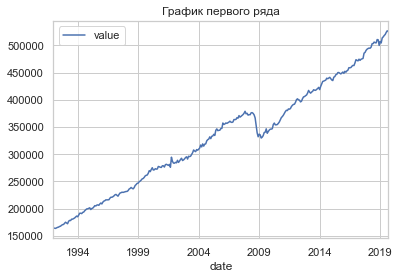

In [325]:
# Построим график первого ряда
sns.set_style()
df1.plot()
plt.title("График первого ряда")

Text(0.5, 1.0, 'График второго ряда')

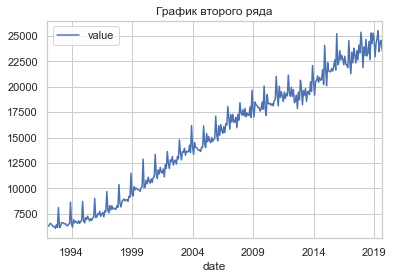

In [326]:
# Построим график второго ряда
sns.set_style()
df2.plot()
plt.title("График второго ряда")

### 2.2. Графики автокорреляционных функций

Text(0.5, 1.0, 'График автокорреляционной функции для первого ряда')

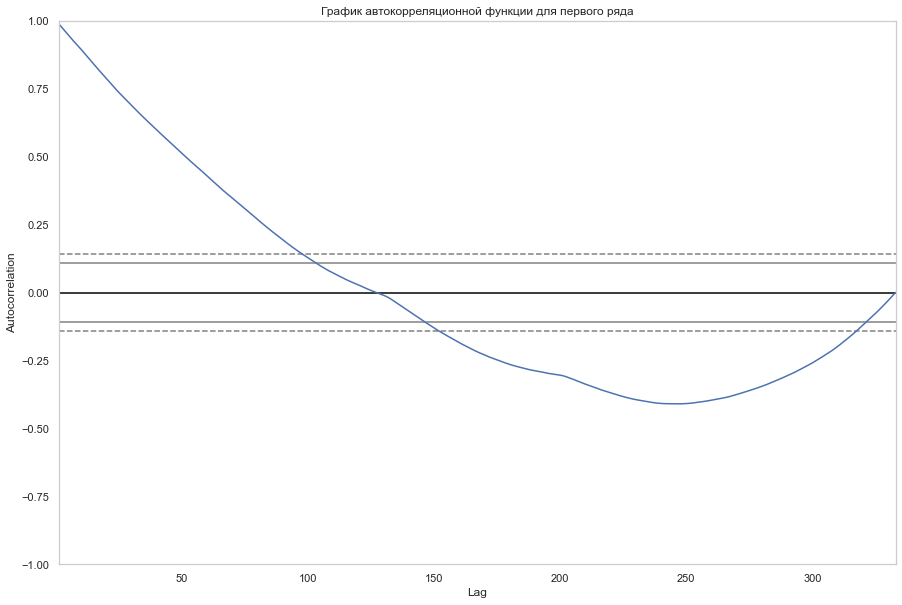

In [327]:
# Построим график автокорреляционной функции для первого ряда
fig = plt.figure(num=None, figsize=(15, 10))
pd.plotting.autocorrelation_plot(df1)
plt.title("График автокорреляционной функции для первого ряда")

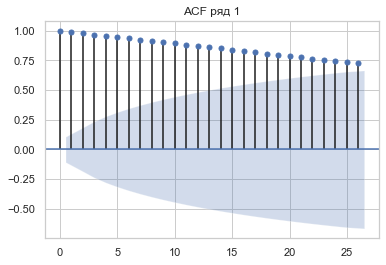

In [328]:
# Другой вариант построить ACF для ряда 1
plot_acf(df1)
plt.title("ACF ряд 1")
plt.show()

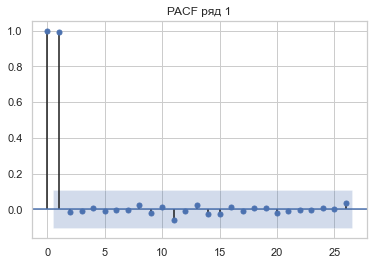

In [329]:
# PACF для ряда 1
plot_pacf(df1)
plt.title("PACF ряд 1")
plt.show()

Text(0.5, 1.0, 'График автокорреляционной функции для второго ряда')

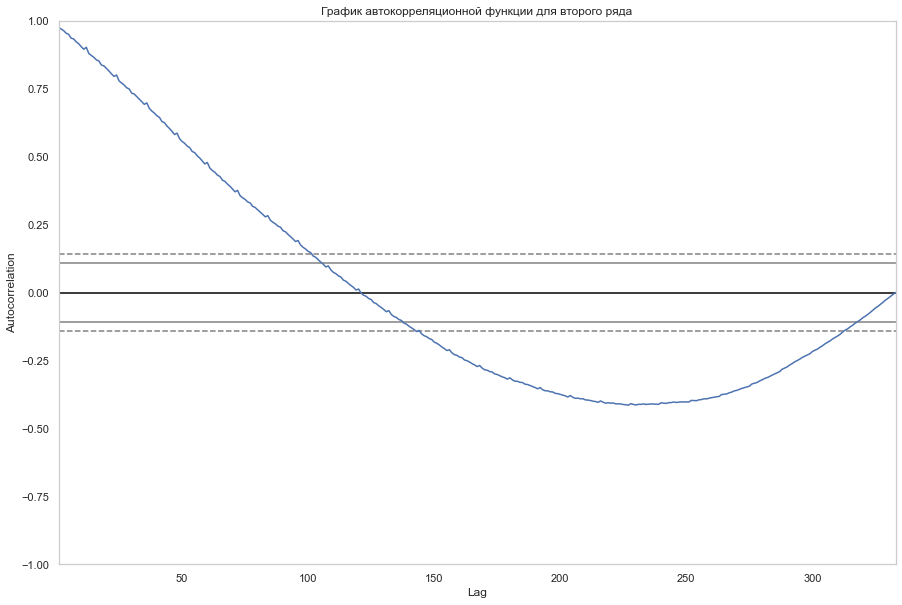

In [330]:
# Построим график автокорреляционной функции для второго ряда
fig = plt.figure(num=None, figsize=(15, 10))
pd.plotting.autocorrelation_plot(df2)
plt.title("График автокорреляционной функции для второго ряда")

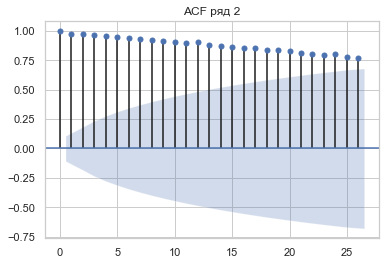

In [331]:
# Другой вариант построить ACF для ряда 2
plot_acf(df2)
plt.title("ACF ряд 2")
plt.show()

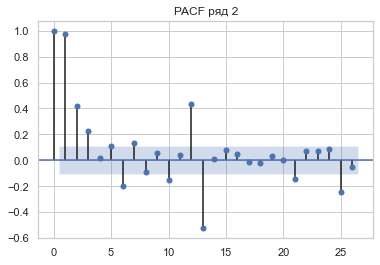

In [332]:
# PACF для ряда 2
plot_pacf(df2)
plt.title("PACF ряд 2")
plt.show()

### 2.3. Графики рядов с нарезкой ряда на годы для иллюстрации сезонности

In [333]:
# Сгруппируем ряды по годам - можно поделить ряд на несколько рядов по годам таким кодом, но мы потыкались и это было не самым удобным

# df1_years = df1.groupby(pd.Grouper(freq='Y'))
# df1_years = df1.groupby(pd.Grouper(freq='Y'))

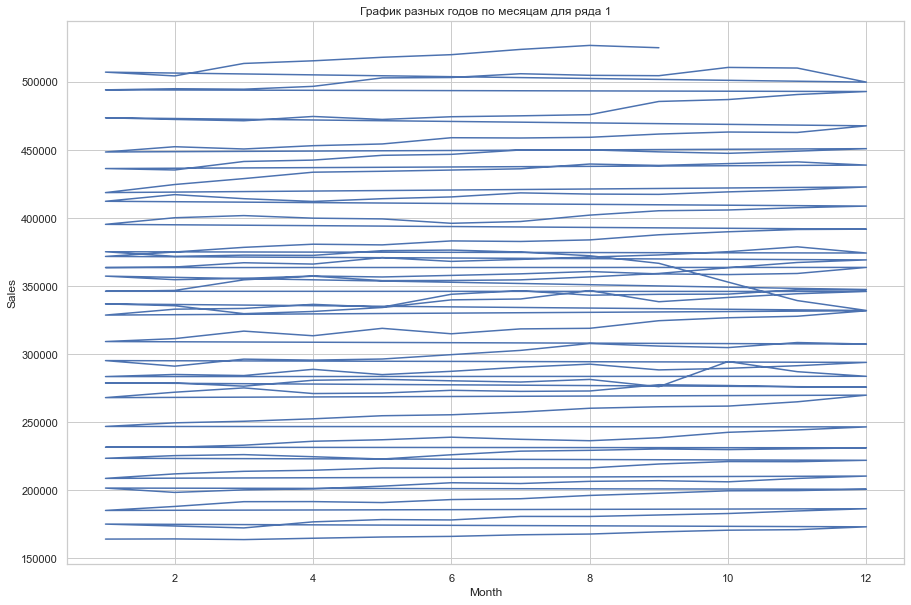

In [334]:
# Стиль графика
sns.set_style("whitegrid")

# Сделаем индексы для месяцев для первого ряда
xindex1 = df1.index.month

# Построим график по месяцам для разных лет
fig = plt.figure(num=None, figsize=(15, 10))
plt.plot(xindex1, df1)
plt.title("График разных годов по месяцам для ряда 1")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

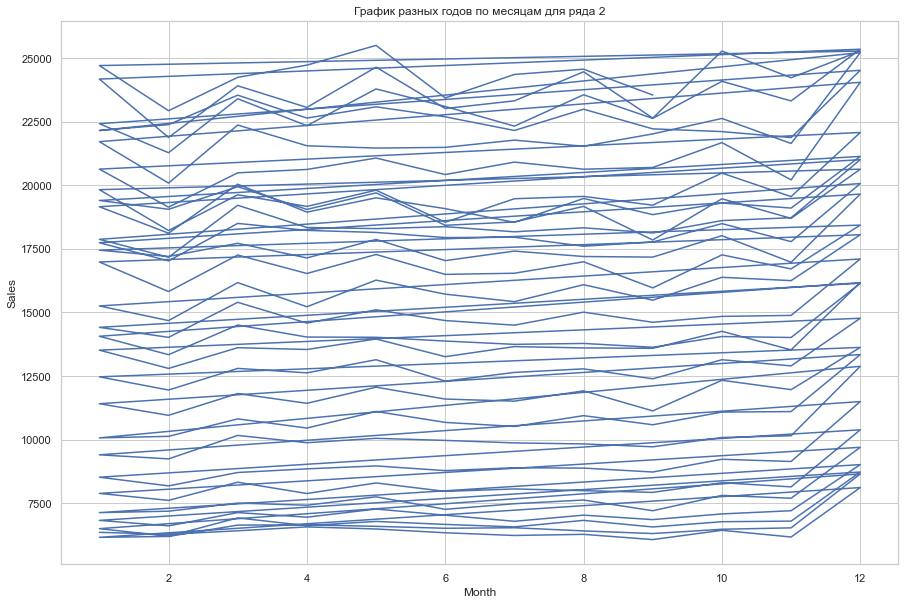

In [335]:
# Стиль графика
sns.set_style("whitegrid")

# Сделаем индексы для месяцев для второго ряда
xindex2 = df2.index.month

# Построим график по месяцам для разных лет
fig = plt.figure(num=None, figsize=(15, 10))
plt.plot(xindex2, df2)
plt.title("График разных годов по месяцам для ряда 2")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

## 3. Твиттер: стационарность, сезонность, тренд, точки излома, амплитуда колебаний

### 3.1. Сезнность

Ряд 1, судя по графикам, не является сезонным: в пункте 2.3. видно, что в разные годы - продажи по месяцам менялись относительно предыдущих месяцев - по-разному

Также для ряда 1 можно заметить, что PACF всегда остается в доверительном интервале

----
Ряд 2, судя по графикм, скорее всего ялвяется сезонным: в пункте 2.3. мы можем заметить, что в разные годы в определенные месяцы, например, в марте (3й месяц) и в декабре (12й месяц) происходит увеличение продаж

Также для ряда 2 можно заметить, что PACF иногда выходит за пределы доверительного интервала, например, на 6-м, 10-м и 13-м лагах.

### 3.2. Стационарность

По графикам из пункта 2.1. видно, что обоих рядах присутствует очень заметный восходящий тренд (графики растут со временем), к тому же во втором ряду также присутствует сезонность. Все это говорит о том, что оба ряда являются нестационарными.

По графикам ACF мы видим, что они уменьшаются с ростом лагов -> это похоже на то, что ряд нестационарен
https://www.machinelearningmastery.ru/detecting-stationarity-in-time-series-data-d29e0a21e638/

Но давайте сделаем тест Дикки-Фуллера, чтобы точно убедиться в том, что ряды нестационарны:

In [336]:
# Тест Дикки-Фуллера для первого ряда:

test1 = sm.tsa.adfuller(df1)

print('adf: ', test1[0])
print('p-value: ', test1[1])
print('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  0.6116008792309576
p-value:  0.9878981076981963
Critical values:  {'1%': -3.4502011472639724, '5%': -2.8702852297358983, '10%': -2.5714292194077513}
есть единичные корни, ряд не стационарен


In [337]:
# Тест Дикки-Фуллера для второго ряда:

test2 = sm.tsa.adfuller(df2)

print('adf: ', test2[0])
print('p-value: ', test2[1])
print('Critical values: ', test2[4])
if test2[0]> test2[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  0.008341959349289923
p-value:  0.959216547224669
Critical values:  {'1%': -3.4512146067362317, '5%': -2.870730188960711, '10%': -2.5716664849383113}
есть единичные корни, ряд не стационарен


### 3.3. Точки излома

Для первого ряда точкой излома является 2008 год, когда график продаж резко упал

Для второго ряда небольшой излом произошел в 2013 году, небольшое, но резкое снижение продаж в этот год

### 3.4. Амплитуда колбений

Судя по графику первого ряда, амплитуда колебаний постоянна на всем исследуемом временном отрезке

Судя по графику второго ряда, амплитуда колебаний непостоянна на всем исследуемом временном отрезке, меняется как месяц к месяцу, так и год к году

### 3.5. Логарифм (если нужно)

Давайте возьмем логарифмы обоих рядов, нам кажется, что это будет полезно посмотреть, учитывая, что продажи учитываются в денежных единицах, которые обычно лоагарифмируют

In [338]:
# Логарифмируем ряды с помощью пакета numpy
df1_log = np.log2(df1)
df2_log = np.log2(df2)

<Figure size 1080x720 with 0 Axes>

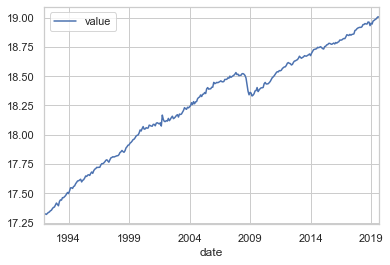

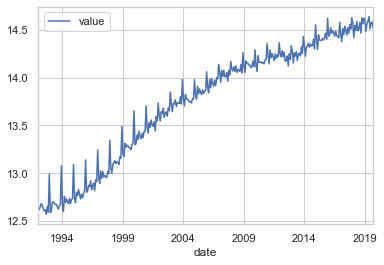

In [339]:
# Построим графики логарифмов
fig = plt.figure(num=None, figsize=(15, 10))
df1_log.plot()
df2_log.plot()

## 4. Двенадцать месяцев: прогнозы 6 разных моделей

Строить модели мы будем не в логарифмах для обоих рядов

Необходимо исследовать качество прогнозов минимум 6 моделей:

- Наивная
- Сезонная наивная
- SARIMA(1, 1, 1)(1, 0, 0)
- Алгоритм Хиндмана-Хандакара автоматического подбора SARIMA
- ETS(AAA)
- ETS с автоматическим выбором по AIC

Сравни качество прогнозов по средней абсолютной ошибке MAE на тестовой выборке. В качестве тестовой выборки возьми последний год наблюдений, в качестве обучающей — все остальные на- блюдения.

На бонусный балл: сравни качество прогнозов по средней абсолютной ошибке MAE на один шаг вперёд с помощью кросс-валидации. Кросс-валидацию проводи растущим окном, начав с окна в 80% исходной выборки.

Подсказка. В питоне могут помочь функции NaiveForecaster, ARIMA, AutoARIMA, ExponentialSmoothing и AutoETS из sktime. В r нужное модели есть в пакете fable, а графики поможет построить feasts. В julia ARIMA и ETS реализованы в пакете StateSpaceModels.

In [472]:
# Для каждого ряда разделим все наблюдения на обучающие и тестовые

obs1 = len(df1)
obs2 = len(df2)

train1 = int(0.8 * obs1)
train2 = int(0.8 * obs2)

df1_train = df1.value[:train1]
df1_test = df1.value[train1:]

df2_train = df2.value[:train2]
df2_test = df2.value[train2:]

df1_train.index

PeriodIndex(['1992-01', '1992-02', '1992-03', '1992-04', '1992-05', '1992-06',
             '1992-07', '1992-08', '1992-09', '1992-10',
             ...
             '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', '2013-10',
             '2013-11', '2013-12', '2014-01', '2014-02'],
            dtype='period[M]', name='date', length=266, freq='M')

In [473]:
# Необходимые дополнительные модули для моделирования

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.ets import AutoETS
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import (MeanAbsoluteError, mean_absolute_error)
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_evaluation import evaluate

In [474]:
# Горизонты планирования для двух рядов
FH1 = ForecastingHorizon(df1_test.index, is_relative=False)
FH2 = ForecastingHorizon(df2_test.index, is_relative=False)

### 4.1. Наивный прогноз

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9305a09730>)

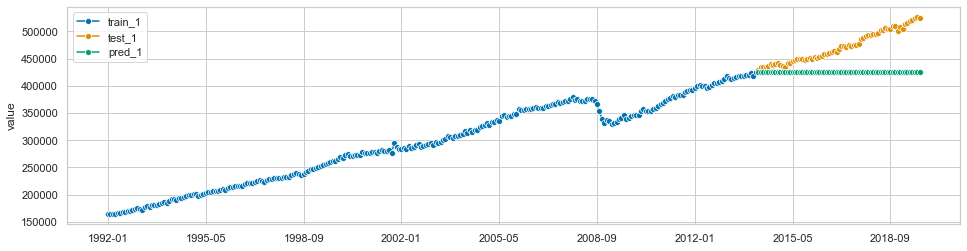

In [475]:
# Обучим модель для первого ряда
naive_forecaster = NaiveForecaster(strategy="last")
naive_forecaster.fit(df1_train)

# Сделаем прогноз
df1_pred = naive_forecaster.predict(FH1)

# Построим графики
plot_series(df1_train, df1_test, df1_pred, labels=["train_1", "test_1", "pred_1"])

In [476]:
# Посмотрим на MAE этого прогноза первого ряда
Naive_1 = mean_absolute_error(df1_pred, df1_test)
print("Mean Abs Error of Naive 1:", Naive_1)

Mean Abs Error of Naive 1: 47438.59701492537


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9305eb54f0>)

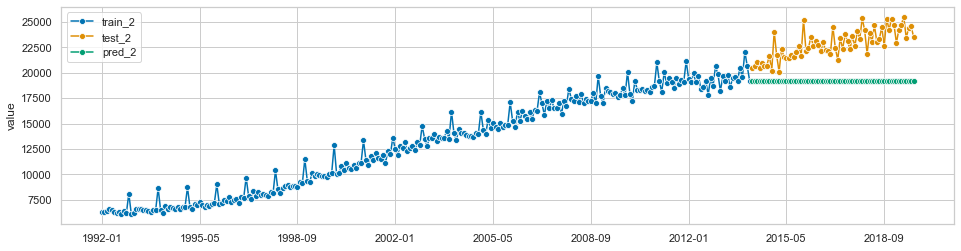

In [477]:
# Обучим модель для второго ряда
naive_forecaster = NaiveForecaster(strategy="last")
naive_forecaster.fit(df2_train)

# Сделаем прогноз
df2_pred = naive_forecaster.predict(FH2)

# Построим графики
plot_series(df2_train, df2_test, df2_pred, labels=["train_2", "test_2", "pred_2"])

In [478]:
# Посмотрим на MAE этого прогноза второго ряда
Naive_2 = mean_absolute_error(df2_pred, df2_test)
print("Mean Abs Error of Naive 2:", Naive_2)

Mean Abs Error of Naive 2: 3666.1641791044776


### 4.2. Сезонный наивный прогноз

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9306297520>)

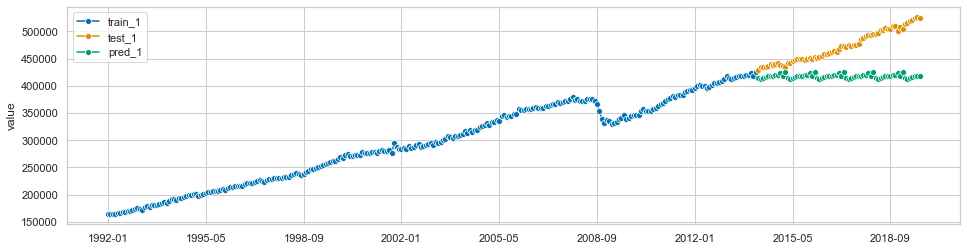

In [479]:
# Обучим модель для первого ряда
seasonal_naive_forecaster = NaiveForecaster(strategy="last", sp=12)
seasonal_naive_forecaster.fit(df1_train)

# Сделаем прогноз
df1_pred = seasonal_naive_forecaster.predict(FH1)

# Построим графики
plot_series(df1_train, df1_test, df1_pred, labels=["train_1", "test_1", "pred_1"])

In [480]:
# Посмотрим на MAE этого прогноза для первого ряда
SNaive_1 = mean_absolute_error(df1_pred, df1_test)
print("Mean Abs Error of Seasonal Naive 1:", SNaive_1)

Mean Abs Error of Seasonal Naive 1: 54341.77611940299


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f93064215b0>)

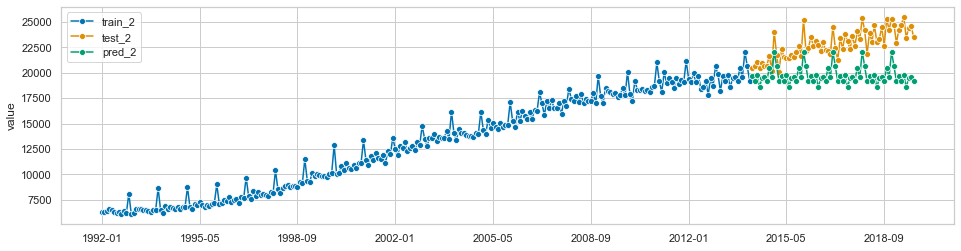

In [481]:
# Обучим модель для второго ряда
seasonal_naive_forecaster = NaiveForecaster(strategy="last", sp=12)
seasonal_naive_forecaster.fit(df2_train)

# Сделаем прогноз
df2_pred = seasonal_naive_forecaster.predict(FH2)

# Построим графики
plot_series(df2_train, df2_test, df2_pred, labels=["train_2", "test_2", "pred_2"])

In [482]:
# Посмотрим на MAE этого прогноза для второго ряда
SNaive_2 = mean_absolute_error(df2_pred, df2_test)
print("Mean Abs Error of Seasonal Naive 2:", SNaive_2)

Mean Abs Error of Seasonal Naive 2: 3078.2537313432836


### 4.3. SARIMA(1, 1, 1)(1, 0, 0)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f930649efa0>)

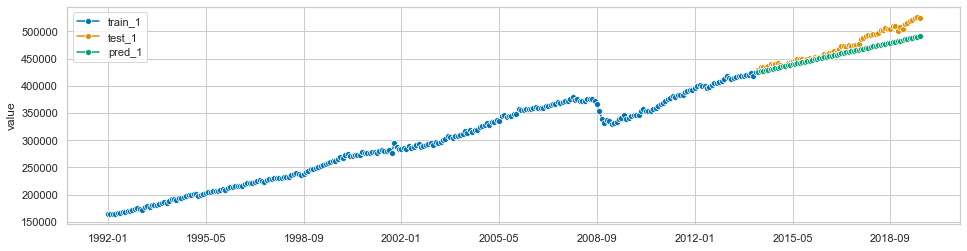

In [483]:
# Обучим модель для первого ряда
SARIMA = ARIMA(order=(1, 1, 1),
                          seasonal_order=(1, 0, 0, 12),
                          suppress_warnings=True)

SARIMA.fit(df1_train)

# Сделаем прогноз
df1_pred = SARIMA.predict(FH1)

# Построим графики
plot_series(df1_train, df1_test, df1_pred, labels=["train_1", "test_1", "pred_1"])

In [484]:
# Посмотрим на MAE этого прогноза для первого ряда
SARIMA_1 = mean_absolute_error(df1_pred, df1_test)
print("Mean Abs Error of SARIMA:", SARIMA_1)

Mean Abs Error of SARIMA: 13751.331558611822


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9305336340>)

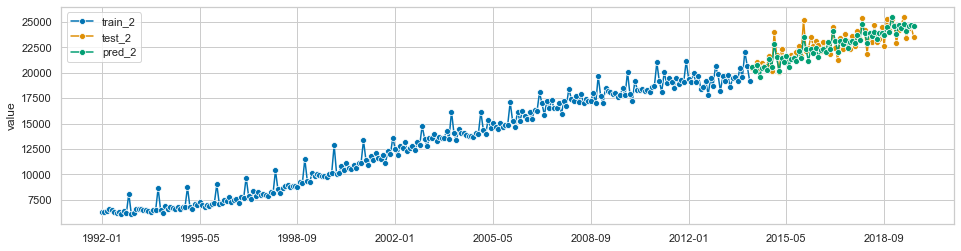

In [485]:
# Обучим модель для второго ряда
SARIMA = ARIMA(order=(1, 1, 1),
                          seasonal_order=(1, 0, 0, 12),
                          suppress_warnings=True)

SARIMA.fit(df2_train)

# Сделаем прогноз
df2_pred = SARIMA.predict(FH2)

# Построим графики
plot_series(df2_train, df2_test, df2_pred, labels=["train_2", "test_2", "pred_2"])

In [486]:
# Посмотрим на MAE этого прогноза для второго ряда
SARIMA_2 = mean_absolute_error(df2_pred, df2_test)
print("Mean Abs Error of SARIMA:", SARIMA_2)

Mean Abs Error of SARIMA: 531.1315286283997


### 4.4. Алгоритм Хиндмана-Хандакара автоматического подбора SARIMA

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9305372be0>)

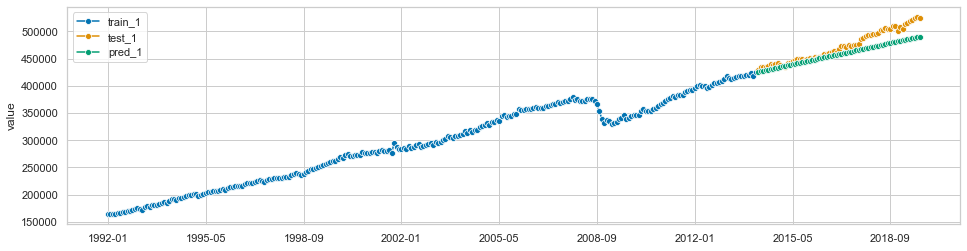

In [487]:
# Обучим модель
a_ARIMA = AutoARIMA(sp=12, suppress_warnings=True)
a_ARIMA.fit(df1_train)

# Сделаем прогноз
df1_pred = a_ARIMA.predict(FH1)

# Построим графики
plot_series(df1_train, df1_test, df1_pred, labels=["train_1", "test_1", "pred_1"])

In [488]:
# Посмотрим на MAE этого прогноза для первого ряда
A_SARIMA_1 = mean_absolute_error(df1_pred, df1_test)
print("Mean Abs Error of auto SARIMA:", A_SARIMA_1)

Mean Abs Error of auto SARIMA: 14042.97313432797


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9308d3bca0>)

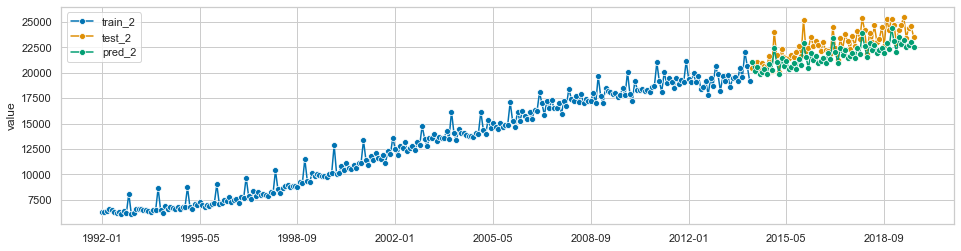

In [489]:
# Обучим модель для второго ряда
a_ARIMA = AutoARIMA(sp=12, suppress_warnings=True)
a_ARIMA.fit(df2_train)

# Сделаем прогноз
df2_pred = a_ARIMA.predict(FH2)

# Построим графики
plot_series(df2_train, df2_test, df2_pred, labels=["train_2", "test_2", "pred_2"])

In [490]:
# Посмотрим на MAE этого прогноза для второго ряда
A_SARIMA_2 = mean_absolute_error(df2_pred, df2_test)
print("Mean Abs Error of auto SARIMA:", A_SARIMA_2)

Mean Abs Error of auto SARIMA: 1114.6989903245733


### 4.5. ETS(AAA)

/Users/alexeysek/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f933fb09100>)

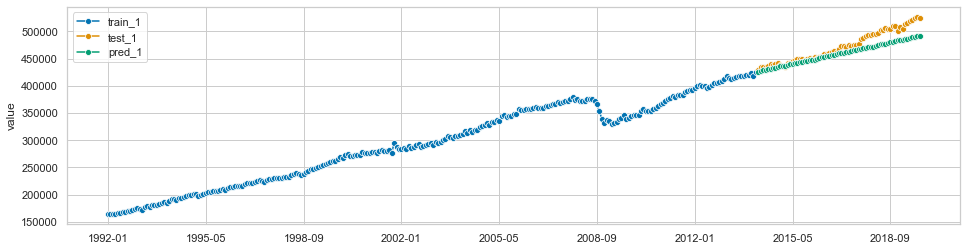

In [491]:
# Обучим модель
ets =  ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
ets.fit = ets.fit(df1_train)

# Сделаем прогноз
df1_pred = ets.predict(FH1)

# Построим графики
plot_series(df1_train, df1_test, df1_pred, labels=["train_1", "test_1", "pred_1"])

In [492]:
# Посмотрим на MAE этого прогноза для первого ряда
ETS_1 = mean_absolute_error(df1_pred, df1_test)
print("Mean Abs Error of ETS(AAA):", ETS_1)

Mean Abs Error of ETS(AAA): 13171.083413144283


/Users/alexeysek/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9339005d90>)

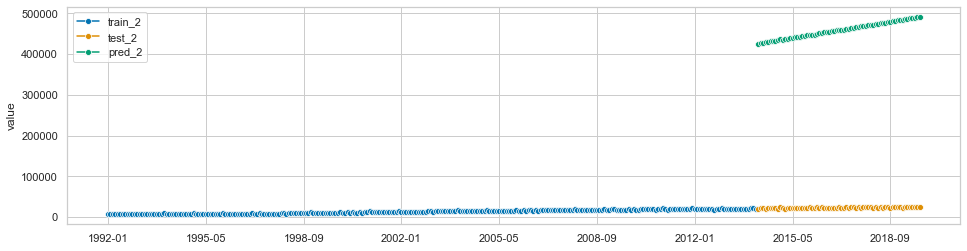

In [493]:
# Обучим модель для второго ряда
ets =  ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
ets.fit = ets.fit(df1_train)

# Сделаем прогноз
df2_pred = ets.predict(FH2)


# Построим графики
plot_series(df2_train, df2_test, df2_pred, labels=["train_2", "test_2", "pred_2"])

In [494]:
# Посмотрим на MAE этого прогноза для второго ряда
ETS_2 = mean_absolute_error(df2_pred, df2_test)
print("Mean Abs Error of ETS(AAA):", ETS_2)

Mean Abs Error of ETS(AAA): 436133.3456134049


### 4.6. ETS с автоматическим выбором по AIC

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9319db3dc0>)

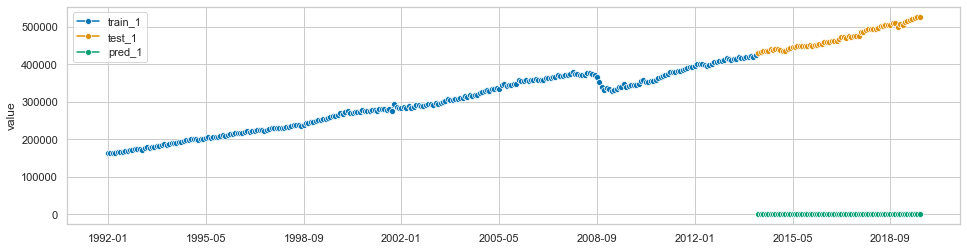

In [495]:
# Обучим модель, у нас не получалось обучить до того, как мы логарифмировали данные
a_ETS = AutoETS(auto=True, sp=12, information_criterion='aic', n_jobs=-1)
a_ETS.fit(np.log(df1_train))

# Сделаем прогноз
df1_pred = a_ETS.predict(FH1)

# Построим графики
plot_series(df1_train, df1_test, df1_pred, labels=["train_1", "test_1", "pred_1"])

In [496]:
# Посмотрим на MAE этого прогноза для первого ряда
A_ETS_1 = mean_absolute_error(df1_pred, df1_test)
print("Mean Abs Error of auto ETS:", A_ETS_1)

Mean Abs Error of auto ETS: 472068.51521956554


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9323e94d00>)

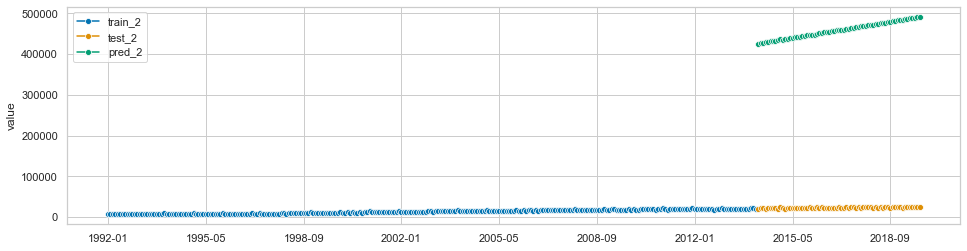

In [497]:
# Обучим модель для второго ряда, у нас не получалось обучить до того, как мы логарифмировали данные, поэтому мы так сделали
a_ETS = AutoETS(auto=True, sp=12, information_criterion='aic', n_jobs=-1)
a_ETS.fit(np.log2(df2_train))

# Сделаем прогноз
df1_pred = a_ETS.predict(FH2)

# Построим графики
plot_series(df2_train, df2_test, df2_pred, labels=["train_2", "test_2", "pred_2"])

In [498]:
# Посмотрим на MAE этого прогноза для второго ряда
A_ETS_2 = mean_absolute_error(df2_pred, df2_test)
print("Mean Abs Error of auto ETS:", A_ETS_2)

Mean Abs Error of auto ETS: 436133.3456134049


## 5. Кто на свете всех милее: выбрать наилучшую модель для каждого ряда и построить прогноз на год, используя все имеющиеся данные (train + test)

### 5.1. Выбираем наилучшую модель

In [518]:
# Соберем все MAE по каждому ряду по каждой модели вместе, чтобы сравнить + округлим до целых
TS_1_MAE = {"Naive" : [int(Naive_1)],
               "Seasonal Naive" : [int(SNaive_1)],
               "SARIMA" : [int(SARIMA_1)],
               "Auto SARIMA" : [int(A_SARIMA_1)],
               "ETS(AAA)" : [int(ETS_1)],
               "Auto ETS" : [int(A_ETS_1)]}

TS_1_MAE = pd.DataFrame.from_dict(TS_1_MAE)

TS_2_MAE = {"Naive" : [int(Naive_2)],
               "Seasonal Naive" : [int(SNaive_2)],
               "SARIMA" : [int(SARIMA_2)],
               "Auto SARIMA" : [int(A_SARIMA_2)],
               "ETS(AAA)" : [int(ETS_2)],
               "Auto ETS" : [int(A_ETS_2)]}

TS_2_MAE = pd.DataFrame.from_dict(TS_2_MAE)

In [519]:
print(TS_1_MAE)

   Naive  Seasonal Naive  SARIMA  Auto SARIMA  ETS(AAA)  Auto ETS
0  47438           54341   13751        14042     13171    472068


Для этого ряда наименьшая MAE в модели ETS(AAA) - 13171

In [520]:
print(TS_2_MAE)

   Naive  Seasonal Naive  SARIMA  Auto SARIMA  ETS(AAA)  Auto ETS
0   3666            3078     531         1114    436133    436133


Для этого ряда наименьшая MAE в модели SARIMA - 531

### 5.2. Строим прогноз, используя все данные, по каждому из рядов

In [566]:
# Горизонт планирования
FH1_all = np.arange(12)
FH2_all = np.arange(12)

/Users/alexeysek/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9307ab07c0>)

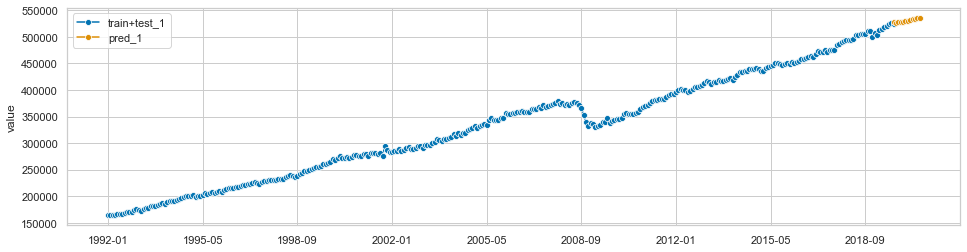

In [556]:
# Лучше для ряда один показала себя модель ETS(AAA), поэтому давайте обучим ее на всей выборке первого ряда

# Обучим модель
ets =  ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
ets.fit = ets.fit(df1.value[:])

# Сделаем прогноз
df1_pred = ets.predict(FH1_all)

# Построим графики
plot_series(df1.value[:], df1_pred, labels=["train+test_1", "pred_1"])

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9308746e80>)

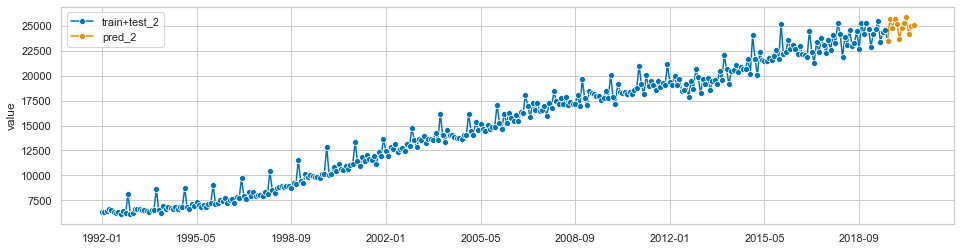

In [567]:
# Лучше для ряда два показала себя модель SARIMA, поэтому давайте обучим ее на всей выборке второго ряда

# Обучим модель для второго ряда
SARIMA = ARIMA(order=(1, 1, 1),
               seasonal_order=(1, 0, 0, 12),
               suppress_warnings=True)

SARIMA.fit(df2.value[:])

# Сделаем прогноз
df2_pred = SARIMA.predict(FH2_all)

# Построим графики
plot_series(df2.value[:], df2_pred, labels=["train+test_2", "pred_2"])

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9308746e80>)

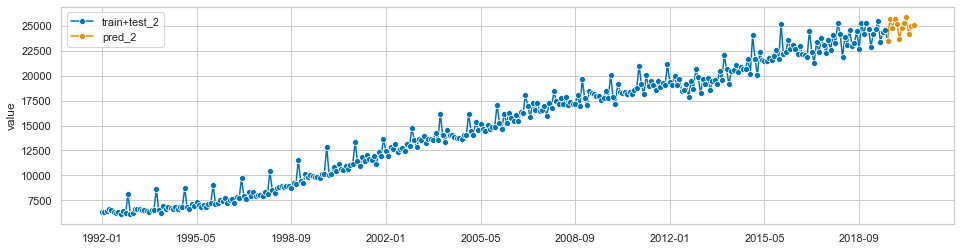

In [567]:
# Лучше для ряда два показала себя модель SARIMA, поэтому давайте обучим ее на всей выборке второго ряда

# Обучим модель для второго ряда
SARIMA = ARIMA(order=(1, 1, 1),
               seasonal_order=(1, 0, 0, 12),
               suppress_warnings=True)

SARIMA.fit(df2.value[:])

# Сделаем прогноз
df2_pred = SARIMA.predict(FH2_all)

# Построим графики
plot_series(df2.value[:], df2_pred, labels=["train+test_2", "pred_2"])

## 6. Хождение в народ: скачать панель RLMS

In [47]:
df,meta = pyreadstat.read_sav(r'C:\Users\manle\OneDrive\Рабочий стол\USER_RLMS-HSE_HH_1994_2019_v3.sav')

In [48]:
df.head()

,ID_W,REDID_H,ID_H,AID_H,BID_H,CID_H,DID_H,EID_H,FID_H,GID_H,...,H6913.6,H6923.6,G1.1,G1.2,G2,G3,G4,G5,G6,G7
0,5.0,1.0,1001.0,1001.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,2.0,2.0,1.0,3.0,3.0,2.0,NaN
1,5.0,2.0,1002.0,1002.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,2.0,1.0,1.0,3.0,3.0,2.0,NaN
2,5.0,3.0,1003.0,1003.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,2.0,1.0,1.0,3.0,3.0,2.0,NaN
3,5.0,4.0,1004.0,1004.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,2.0,1.0,1.0,3.0,3.0,2.0,NaN
4,5.0,5.0,1005.0,1005.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,2.0,1.0,1.0,3.0,3.0,3.0,NaN


In [6]:
data = df.set_index(['ID_H', 'ID_W'])

In [7]:
print(data.head())

             REDID_H   AID_H  BID_H  CID_H  DID_H  EID_H  FID_H  GID_H  HID_H  \
ID_H   ID_W                                                                     
1001.0 5.0       1.0  1001.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1002.0 5.0       2.0  1002.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1003.0 5.0       3.0  1003.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1004.0 5.0       4.0  1004.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1005.0 5.0       5.0  1005.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

             IID_H  ...  H6913.6  H6923.6  G1.1  G1.2   G2   G3   G4   G5  \
ID_H   ID_W         ...                                                     
1001.0 5.0     NaN  ...      NaN      NaN   2.0   2.0  2.0  1.0  3.0  3.0   
1002.0 5.0     NaN  ...      NaN      NaN   1.0   2.0  1.0  1.0  3.0  3.0   
1003.0 5.0     NaN  ...      NaN      NaN   2.0   2.0  1.0  1.0  3.0  3.0   
1004.0 5.0     NaN  ...      NaN      NaN   2.0

## 7. Кому на Руси жить хорошо: Сформулируй пусть не особо глубокий, но всё же вопрос

«Помогает ли потребление огурцов домодчадцами предсказать доход главы семейства?» вполне до-
статочно. В данных RLMS много пропусков, поэтому погоня за большим количество предикторов
приведёт к выбрасыванию всех наблюдений. Для данного игрового задания одного предиктора до-
статочно.

In [45]:
df1=df.loc[:,['G6','F14','ID_H','ID_W']]
data_for_work = df1.set_index(['ID_H', 'ID_W'])
print(data_for_work.head())

              G6        F14
ID_H   ID_W                
1001.0 5.0   2.0  1500000.0
1002.0 5.0   2.0  1329000.0
1003.0 5.0   2.0   140000.0
1004.0 5.0   2.0   156000.0
1005.0 5.0   3.0   670000.0


## 8. Сделай красиво: Визуализируй данные с целью графического ответа на поставленный вопрос

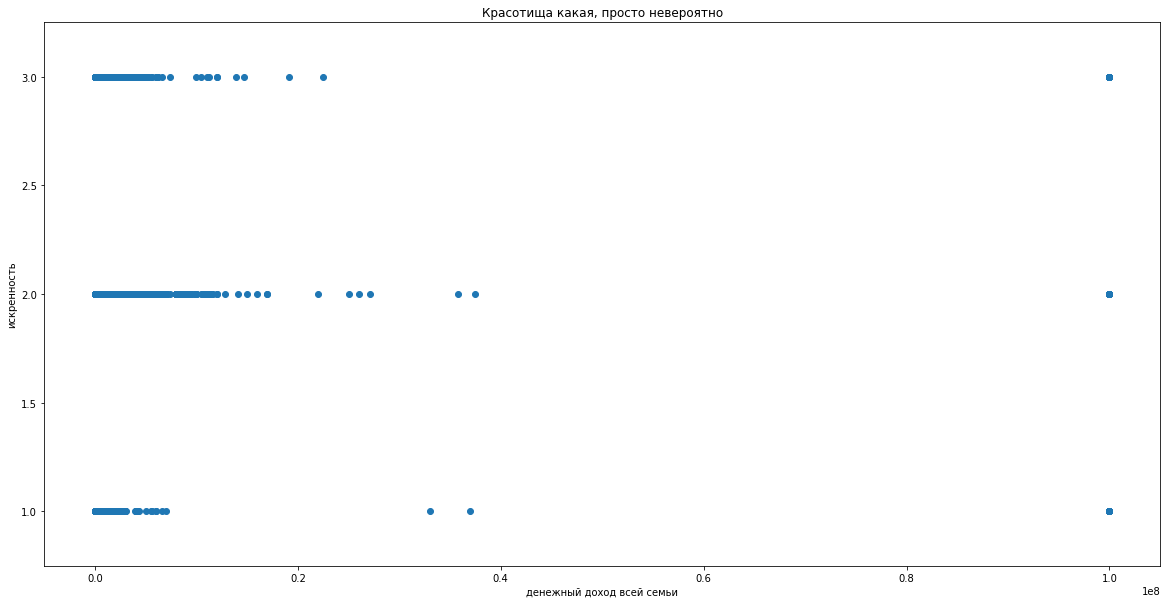

In [61]:
import matplotlib
plt.figure(figsize=[20,10])
matplotlib.pyplot.scatter(data_for_work['F14'], data_for_work['G6'])
plt.title('Красотища какая, просто невероятно')
plt.ylabel('искренность')
plt.ylim(0.75,3.25)
plt.xlabel('денежный доход всей семьи')
plt.show()

## 9. Три сестры: оцени три модели

### 9.1. Cквозная модель

In [50]:
from linearmodels.panel import PooledOLS
pooled = PooledOLS(data_for_work.F14, data_for_work.G6)
print(pooled.fit())

C:\Users\manle\anaconda3\lib\site-packages\linearmodels\shared\exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PooledOLS Estimation Summary                          
Dep. Variable:                    F14   R-squared:                        0.0005
Estimator:                  PooledOLS   R-squared (Between):              0.0015
No. Observations:              107939   R-squared (Within):              -0.0004
Date:                Tue, Jun 15 2021   R-squared (Overall):              0.0005
Time:                        16:36:52   Log-likelihood                -1.965e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      58.982
Entities:                       26389   P-value                           0.0000
Avg Obs:                       4.0903   Distribution:                F(1,107938)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             58.982
                            

### 9.2. FE-модель

In [53]:
from linearmodels.panel import PanelOLS
fixed = PanelOLS(data_for_work.F14, data_for_work.G6, entity_effects=True)
print(fixed.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:                    F14   R-squared:                     2.657e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0004
No. Observations:              107939   R-squared (Within):            2.657e-05
Date:                Tue, Jun 15 2021   R-squared (Overall):              0.0002
Time:                        16:40:11   Log-likelihood                 -1.93e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.1672
Entities:                       26389   P-value                           0.1410
Avg Obs:                       4.0903   Distribution:                 F(1,81549)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             2.1672
                            

### 9.3. RE-модель

In [54]:
from linearmodels.panel import RandomEffects
random = RandomEffects(data_for_work.F14, data_for_work.G6)
print(random.fit())

C:\Users\manle\anaconda3\lib\site-packages\linearmodels\shared\exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                        RandomEffects Estimation Summary                        
Dep. Variable:                    F14   R-squared:                        0.0002
Estimator:              RandomEffects   R-squared (Between):              0.0009
No. Observations:              107939   R-squared (Within):           -4.809e-05
Date:                Tue, Jun 15 2021   R-squared (Overall):              0.0004
Time:                        16:41:09   Log-likelihood                -1.944e+06
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      18.812
Entities:                       26389   P-value                           0.0000
Avg Obs:                       4.0903   Distribution:                F(1,107938)
Min Obs:                       1.0000                                           
Max Obs:                       16.000   F-statistic (robust):             18.812
                            

$\textbf{Сквозная модель является наилучшей из представленных моделей}$

## 10. Ответ на главный вопрос

Ответ на главный вопрос». Ответь на поставленный вопрос.

Можно сделать вывод, что Искренность респондента при дачи отаетов в ходе опроса помогает оценить совокупный доход семейства, так как F-статистика =59, а p-value=0 ( впрочем, чисто интуинтивно, я не уверен в результатах модели, так как я сомневаюсь в способности интервьюэра определить искренность опрашиваемого, впрочем почему не предположить, что опрос проводили люди разбирающиеся в психологии).